# Eccentricity Analysis

In [1]:
import numpy as np
import femagtools
import logging
import matplotlib.pyplot as plt

In [2]:
machine1 = {
    'name': 'IPM-4',
    'dxffile':{'name':'IPM4.dxf', 'plot': True},
    'lfe': 0.1,
    'stator': {'mcvkey_yoke':'M400-50A'},
    'magnet': {'mcvkey_yoke':'M400-50A'},
    'winding': {'num_phases':3, 'num_layers': 1, 'num_wires':10, 'coil_span':3,
                'num_par_wdgs': 1,
               'fillfac':0.42, 'culength':1.6}
}

In [3]:
import pathlib
workdir = pathlib.Path('ipm')
workdir.mkdir(exist_ok=True)
femag = femagtools.Femag(workdir, magnetizingCurves='.')

In [4]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')

2024-06-10 08:14:11,213 search file M400-50A.MCV in /home/tar/femag/VEM
2024-06-10 08:14:11,213 search file M400-50A.MCV in /home/tar/femag/VEM
2024-06-10 08:14:11,214 Copy file M400-50A.MCV
2024-06-10 08:14:11,215 create new model 'IPM-4'
2024-06-10 08:14:11,336 ***** start processing IPM4 *****
2024-06-10 08:14:12,885 total elements 292
2024-06-10 08:14:12,973 check for full machine
2024-06-10 08:14:13,001  - it is full
2024-06-10 08:14:13,661 === airgap is 34.25 ===
2024-06-10 08:14:14,110 *** Begin symmetry search for inner ***
2024-06-10 08:14:14,195  - inner: symmetry axis found
2024-06-10 08:14:15,433 *** End of symmetry search for inner (symmetry and mirror) ***
2024-06-10 08:14:15,434 *** Begin symmetry search for outer ***
2024-06-10 08:14:15,816  - outer: symmetry axis found
2024-06-10 08:14:21,718 *** End of symmetry search for outer (symmetry and mirror) ***
2024-06-10 08:14:22,162 ***** END of work: IPM4 *****


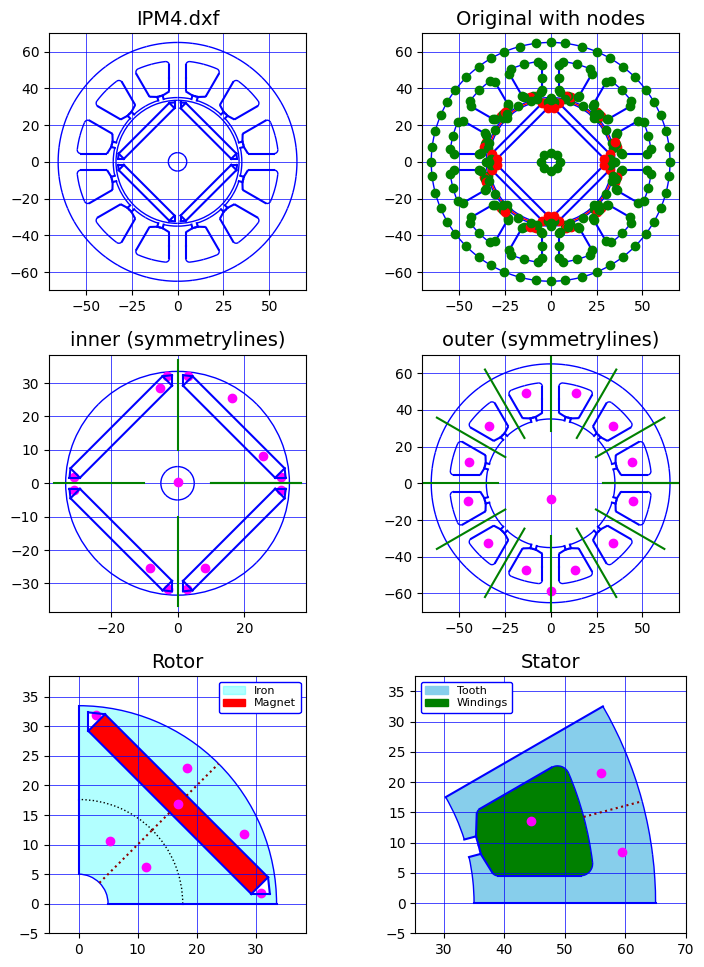

2024-06-10 08:14:23,171 Num nodes/p 96 Num nodes/slot 32 nodedist 1
2024-06-10 08:14:23,341 -- all done in 12.0041 seconds --
2024-06-10 08:14:23,341  num poles 4 num slots 12 outer diameter 0.1300 m
2024-06-10 08:14:23,364 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-10 08:14:23,388  > FSL...exe "femag.fsl"
2024-06-10 08:14:23,389  > New model "IPM-4", ""
2024-06-10 08:14:25,260  > Save model and continue
2024-06-10 08:14:25,285  > FSL...halt
2024-06-10 08:14:25,291 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)


In [5]:
r = femag(machine1)

Calculate current angles (D axis) and move steps

In [6]:
machine1.update({k: r['model'][k] for k in r['model'] if k != 'stator'})
simulation = {
    "error_perm": 0.05,
    "angl_i_up": 0.0,
    "calculationMode": "cogg_calc",
    "eval_force": 1,
    "magn_temp": 20,
    "speed": 4000/60,
    "period_frac": 6,
    "num_par_wdgs": machine1['winding']['num_par_wdgs']
}
r = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-10 08:14:25,297 Poc file IPM-4_4p.poc
2024-06-10 08:14:25,309 create simulation 'cogg_calc'
2024-06-10 08:14:25,315 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-10 08:14:25,337  > FSL...exe "femag.fsl"
2024-06-10 08:14:32,025  > Load model "IPM-4"Save model and close files
2024-06-10 08:14:32,061  > FSL...halt
2024-06-10 08:14:32,067 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-10 08:14:32,068 Read BCH ipm/IPM-4_063.BATCH


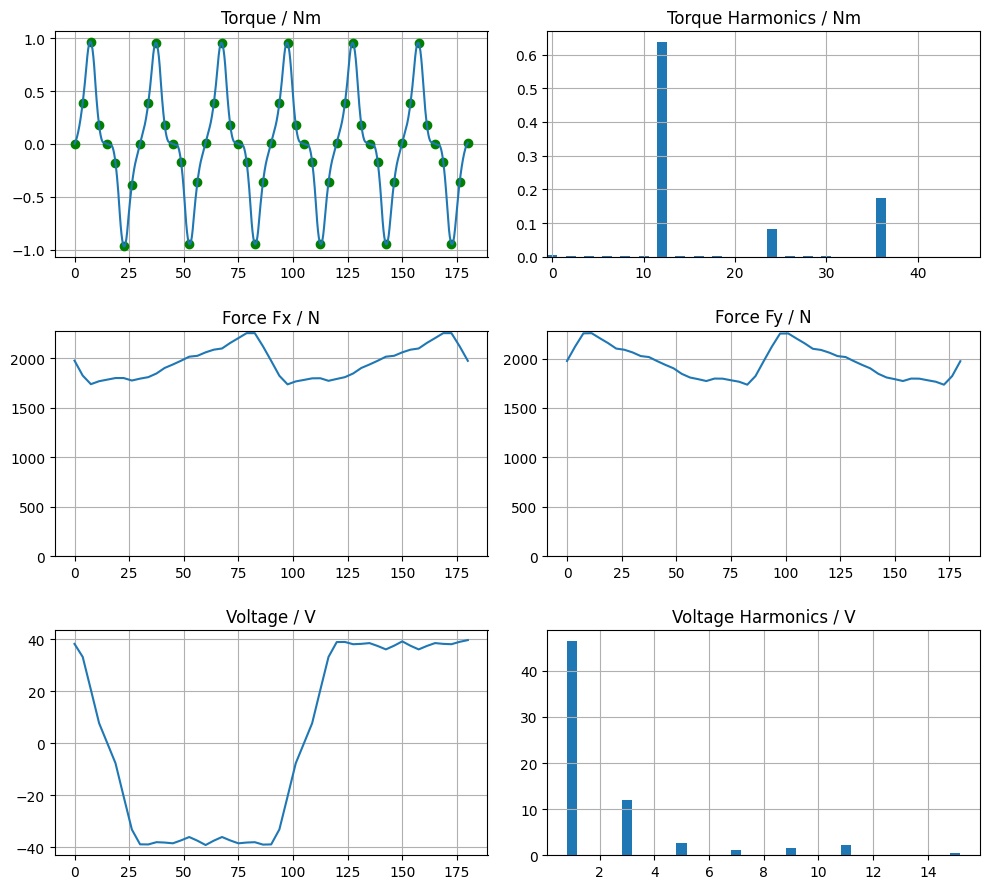

In [7]:
import femagtools.plot
femagtools.plot.cogging(r)

In [8]:
r.current_angles

[210.0, 330.0, 90.0]

In [9]:
machine1['current_angles'] = r.current_angles
num_move_steps = len(r.flux['1'][0]['displ'])-1

Calculate force density without eccentricity

In [10]:
simulation = {
    "angl_i_up": 0.0,
    "calculationMode": "pm_sym_fast",
    "wind_temp": 120.0,
    "magn_temp": 70.0,
    "current": 50,
    "speed": 4000/60,
    "calc_noload": 0,
    "eval_force": 1,
    "period_frac": 6,
    "num_move_steps": num_move_steps+1,
    "poc":femagtools.poc.Poc(current_angles=machine1['current_angles']),
    "num_par_wdgs": machine1['winding']['num_par_wdgs']
}
r = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-10 08:14:32,836 Poc file sin_4p.poc
2024-06-10 08:14:32,849 create simulation 'pm_sym_fast'
2024-06-10 08:14:32,857 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-10 08:14:32,880  > FSL...exe "femag.fsl"
2024-06-10 08:14:40,857  > Load model "IPM-4"Save model and close files
2024-06-10 08:14:40,894  > FSL...halt
2024-06-10 08:14:40,918 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-10 08:14:40,919 Read BCH ipm/IPM-4_064.BATCH


Force density:

In [11]:
fd0 = femag.read_forcedens()

2024-06-10 08:14:40,927 Read PLT0 ipm/IPM-4_027.PLT0
2024-06-10 08:14:40,938 ipm/IPM-4_027.PLT0 shape (49, 97): pos (0.0, 180.0), FN (-7215.69, 579667.31) position,unit,column_units,X,FN,FT,Radius,B_N,B_T


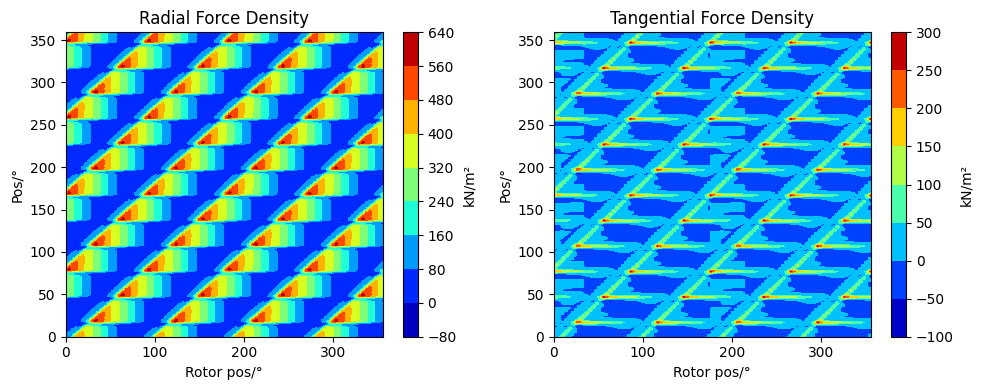

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
femagtools.plot.forcedens_contour(fd0, attr='FN', ax=axs[0])
femagtools.plot.forcedens_contour(fd0, attr='FT', ax=axs[1])
fig.tight_layout()

Build full model (without plots)

In [13]:
machine1['dxffile'] = {'name':'IPM4.dxf', 'full_model':True}
r = femag(machine1)

2024-06-10 08:14:41,412 Copy file M400-50A.MCV
2024-06-10 08:14:41,413 create new model 'IPM-4'
2024-06-10 08:14:41,414 ***** start processing IPM4 *****
2024-06-10 08:14:43,311 total elements 292
2024-06-10 08:14:43,421 check for full machine
2024-06-10 08:14:43,453  - it is full
2024-06-10 08:14:43,770 === airgap is 34.25 ===
2024-06-10 08:14:44,309 *** Begin symmetry search for inner ***
2024-06-10 08:14:44,410  - inner: symmetry axis found
2024-06-10 08:14:44,549 *** End of symmetry search for inner (symmetry and mirror) ***
2024-06-10 08:14:44,550 *** Begin symmetry search for outer ***
2024-06-10 08:14:44,941  - outer: symmetry axis found
2024-06-10 08:14:45,284 *** End of symmetry search for outer (symmetry and mirror) ***
2024-06-10 08:14:45,738 ***** END of work: IPM4 *****
2024-06-10 08:14:45,739 Num nodes/p 96 Num nodes/slot 32 nodedist 1
2024-06-10 08:14:45,910 -- all done in 4.4958 seconds --
2024-06-10 08:14:45,911  num poles 4 num slots 12 outer diameter 0.1300 m
2024-06

In [14]:
r

{'status': 'ok',
 'message': 'IPM-4',
 'model': {'name': 'IPM-4',
  'poles': 4,
  'outer_diam': 0.13000003059029286,
  'airgap': 0.0014999947484759133,
  'bore_diam': 0.06999999565274845,
  'external_rotor': False,
  'agndst': 0.0005604143219056166,
  'stator': {'num_slots': 12, 'num_slots_gen': 12}}}

2024-06-10 08:15:02,765 Total nodes 14938 elements 29223 superelements 79 subregions 14


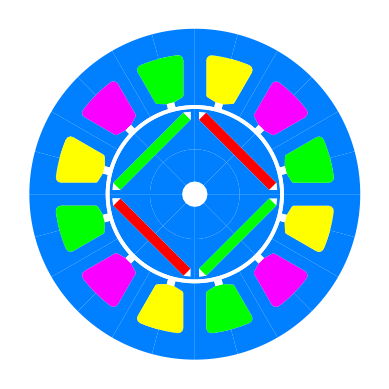

In [15]:
import femagtools.plot
nc = femag.read_nc()
femagtools.plot.spel(nc)

Number of elements in airgap:

In [16]:
da1=machine1['bore_diam']
ag=machine1['airgap']
agndst=machine1['agndst']
np.pi*(da1-ag)/agndst

384.0

In [17]:
num_move_steps = int(np.pi*(da1-ag)/agndst)//machine1['poles']

In [18]:
num_move_steps

96

In [19]:
simulation = {
    "explicit_mode": 1,
    "angl_i_up": 0.0,
    "calculationMode": "pm_sym_fast",
    "wind_temp": 120.0,
    "magn_temp": 70.0,
    "current": 50,
    "speed": 4000/60,
    "calc_noload": 0,
    "eval_force": 1,
    "period_frac": 6,
    "num_move_steps": num_move_steps+1,
    "poc":femagtools.poc.Poc(current_angles=machine1['current_angles']),
    "range_phi": 180,
    "num_par_wdgs": machine1['winding']['num_par_wdgs'],
    'airgap_induc': True
}
r0 = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-10 08:15:03,265 Poc file sin_4p.poc
2024-06-10 08:15:03,283 create simulation 'pm_sym_fast'
2024-06-10 08:15:03,293 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-10 08:15:03,319  > FSL...exe "femag.fsl"
2024-06-10 08:15:49,212  > Load model "IPM-4"Save model and close files
2024-06-10 08:15:49,343  > FSL...halt
2024-06-10 08:15:49,371 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-10 08:15:49,373 Read BCH ipm/IPM-4_065.BATCH
2024-06-10 08:15:49,378 flux density: 4 poles B amp 0.770314 


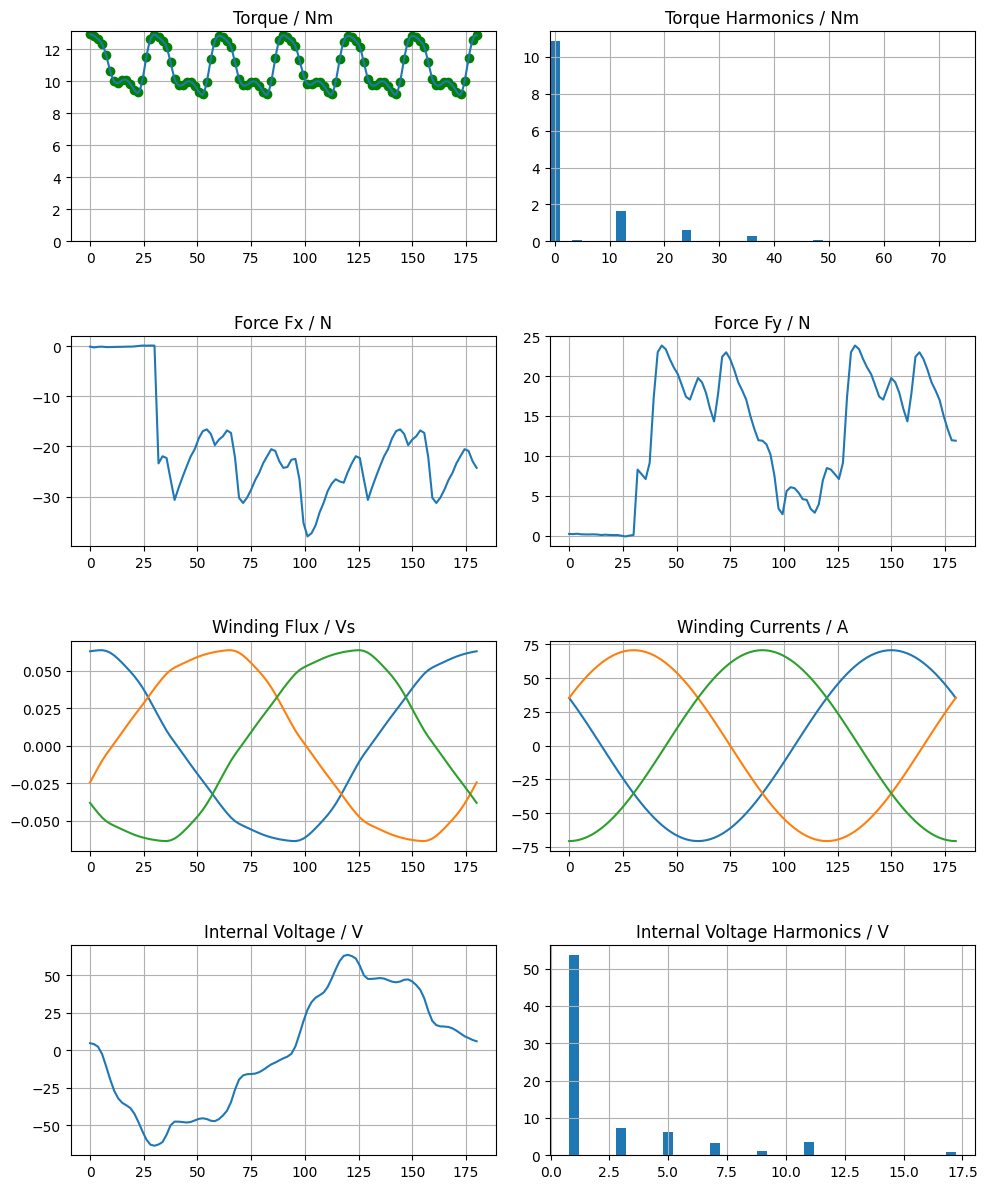

In [20]:
femagtools.plot.pmrelsim(r0)

Flux density in airgap:

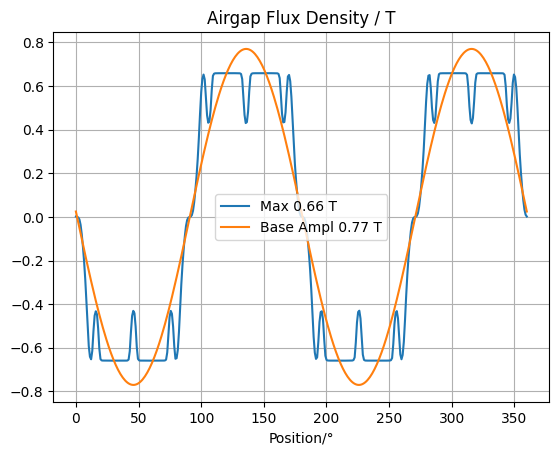

In [21]:
femagtools.plot.airgap(r0.airgap)

2024-06-10 08:15:50,682 Read PLT0 ipm/IPM-4_028.PLT0
2024-06-10 08:15:50,766 ipm/IPM-4_028.PLT0 shape (97, 386): pos (0.0, 180.0), FN (-7348.18, 583140.94) position,unit,column_units,X,FN,FT,Radius,B_N,B_T


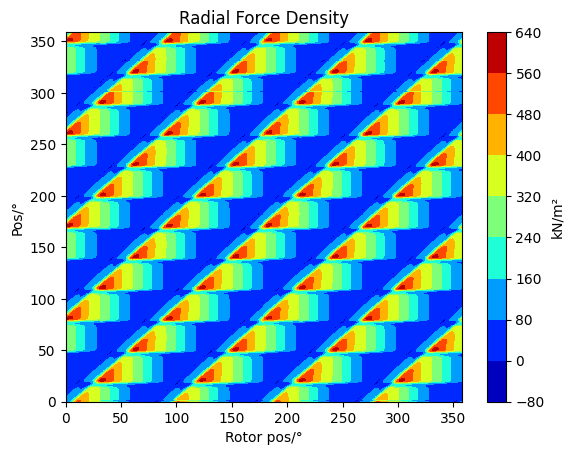

In [22]:
fd1 = femag.read_forcedens()
femagtools.plot.forcedens_contour(fd1)

Check if step distances are equal:

In [23]:
np.diff(r0.flux['1'][0]['displ'])

array([1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875])

Calculate with static eccentricity of 0.4mm:

In [25]:
simulation.update({
    "eccentricity": {'type':'static', 'bore_diam': machine1['bore_diam'], 
                     'airgap': machine1['airgap'], 'ecc': 0.4e-3}})
r = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-10 08:22:49,851 Poc file sin_4p.poc
2024-06-10 08:22:49,863 create simulation 'pm_sym_fast'
2024-06-10 08:22:49,872 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-10 08:22:49,896  > FSL...exe "femag.fsl"
2024-06-10 08:26:08,535  > Load model "IPM-4"Save model and close files
2024-06-10 08:26:08,668  > FSL...halt
2024-06-10 08:26:08,698 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-10 08:26:08,700 Read BCH ipm/IPM-4_066.BATCH
2024-06-10 08:26:08,704 flux density: 4 poles B amp 0.773439 


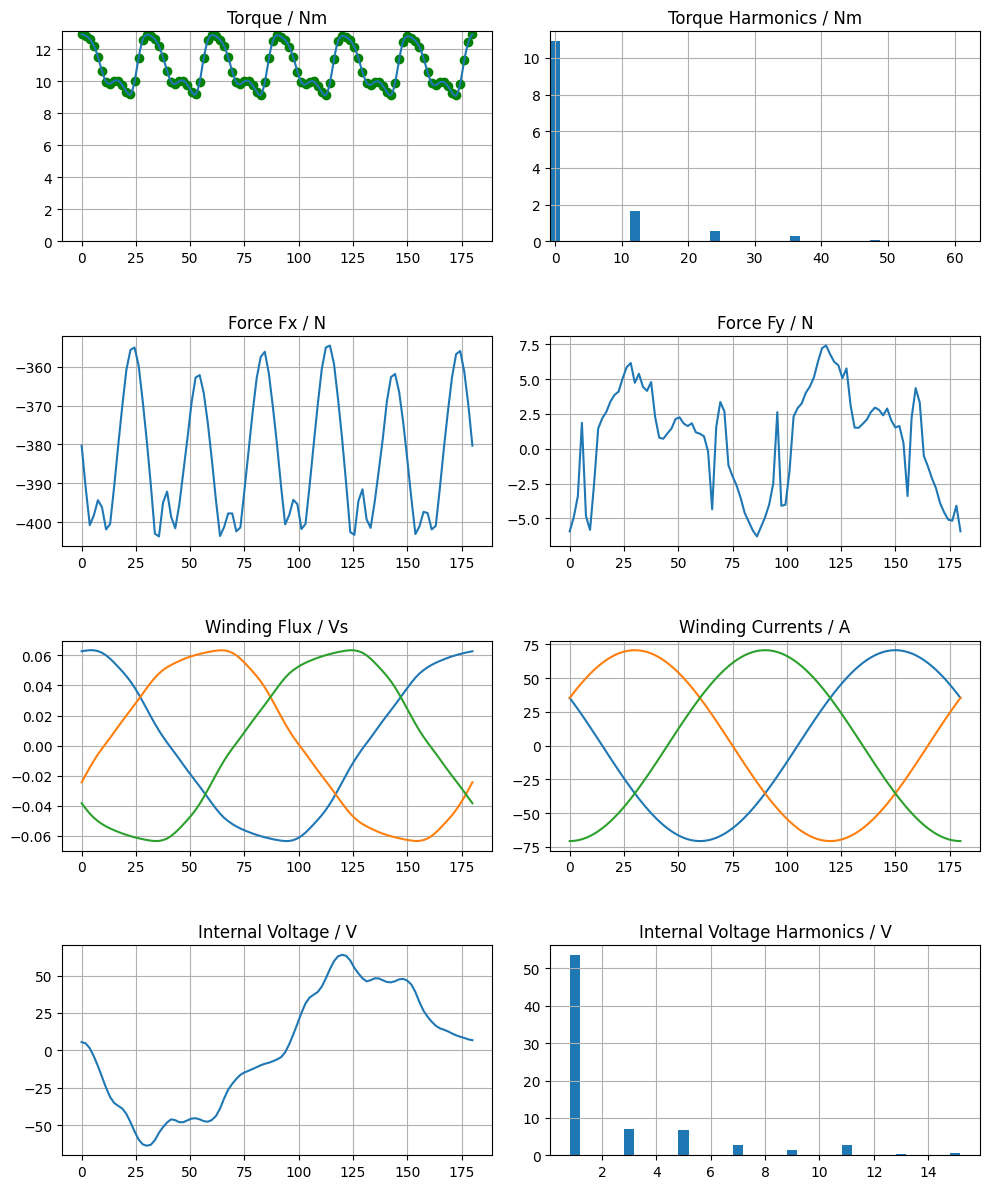

In [26]:
femagtools.plot.pmrelsim(r)

Flux density in airgap:

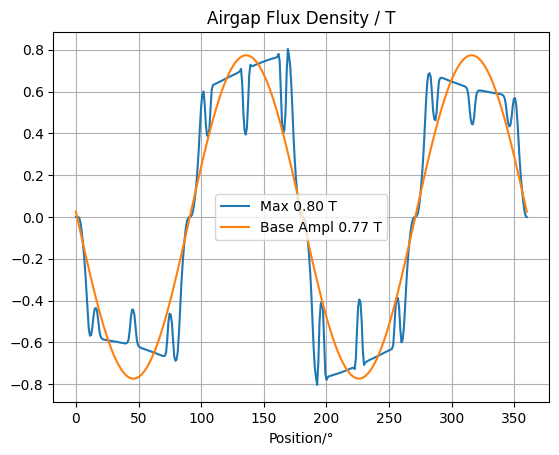

In [27]:
femagtools.plot.airgap(r.airgap)

In [28]:
fd = femag.read_forcedens()

2024-06-10 08:29:06,818 Read PLT0 ipm/IPM-4_029.PLT0
2024-06-10 08:29:06,894 ipm/IPM-4_029.PLT0 shape (97, 386): pos (0.0, 180.0), FN (-9498.98, 878411.06) position,unit,column_units,X,FN,FT,Radius,B_N,B_T


Comparison of force densities without (top) and with eccentricity (bottom)

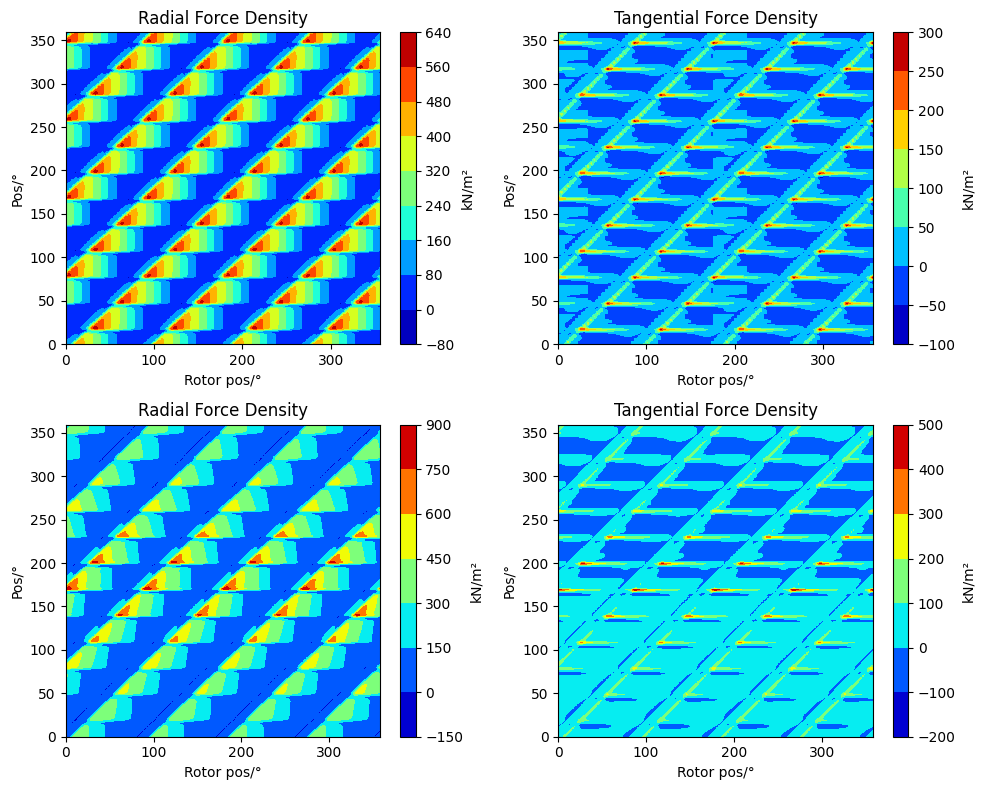

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
femagtools.plot.forcedens_contour(fd0, attr='FN', ax=axs[0, 0])
femagtools.plot.forcedens_contour(fd0, attr='FT', ax=axs[0, 1])
femagtools.plot.forcedens_contour(fd, attr='FN', ax=axs[1, 0])
femagtools.plot.forcedens_contour(fd, attr='FT', ax=axs[1, 1])
fig.tight_layout()